In [1]:
import spotipy as sp
import spotipy.util as util

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt


%matplotlib inline
plt.style.use = "default"
%config InlineBackend.figure_format = "retina"

try:
    import seaborn as sb
    sb.set_style('white')
    sb.set_context("notebook")
except:
    pass


def percentile(values, alpha):

    sort = np.sort(values)
    index = alpha * (len(values) - 1)

    # Get floor and ceiling of current index (we will just assume the need to interpolate)
    floor = int(np.floor(index))
    ceil = int(np.ceil(index))

    maxim = ceil - index

    # Set the value as a weighted sum of both values
    interpolation = sort[floor] * maxim + sort[ceil] * (1 - maxim)

    return interpolation


def get_playlist_tracks(username, playlist_id):

    results = s.user_playlist_tracks(username, playlist_id)
    tracks = results['items']
    
    while results['next']:
        results = s.next(results)
        tracks.extend(results['items'])
        
    return tracks


def get_track_ids(tracks):
    """Collect all track id's in a list of tracks"""
    
    return [track['track']['id'] for track in tracks]


def get_audio_features(ids):
    """Collect all audio features in a list from a given list of track id's"""
    audio_feats = []

    for i in range(0, len(ids), 100):
        audio_feats += s.audio_features(ids[i:i + 100])

    return audio_feats


def extract_feature(features, feature):
    """
    It's apparently possible for songs to not have a specific feature,
    perhaps these are very old songs ? cannot use a simple list comprehension
    because of it
    """
    f = []
    for track in features:
        if track != None:
            f.append(track[feature])
            
    return f


def hist_of_feature(feat, genre1, genre2):
    """
    Helper function to plot both genre's histogram of a specific feature
    the genre titles are hardcoded
    """
    
    genre1_feat = extract_feature(genre1, feat)
    genre2_feat = extract_feature(genre2, feat)

    plt.figure(figsize=(18, 8))

    plt.subplot(121)
    plt.hist(genre1_feat, normed=True, bins=50)
    plt.title("Feature '{0}' for Country".format(feat))
    plt.xlabel("{0} rating".format(feat))

    plt.subplot(122)
    plt.hist(genre2_feat, normed=True, bins=50)
    plt.title("Feature '{0}' for Hip Hop & R&B".format(feat))
    plt.xlabel("{0} rating".format(feat))

    plt.show()

    return genre1_feat, genre2_feat

/home/douwe/.local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
SPOTIPY_REDIRECT_URI='http://localhost:8888/callback'
SPOTIPY_CLIENT_SECRET='c02f97ddd119470d8e24b290722c7490'
SPOTIPY_CLIENT_ID='647ffb8c163b4882be0cafe4bf1352d5'
USERNAME='lh7smhcywr18vctg4xmnoehzu'
SCOPE='user-library-read'

token = util.prompt_for_user_token(username=USERNAME,
                           scope=SCOPE,
                           client_id=SPOTIPY_CLIENT_ID,
                           client_secret=SPOTIPY_CLIENT_SECRET,
                           redirect_uri=SPOTIPY_REDIRECT_URI)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?redirect_uri=http%3A%2F%2Flocalhost%3A8888%2Fcallback&scope=user-library-read&client_id=647ffb8c163b4882be0cafe4bf1352d5&response_type=code in your browser


Enter the URL you were redirected to: http://localhost:8888/callback?code=AQBDrox59zoumzgMBk5UBWeQHU1BK3ejZaW6zzZr6UP_v84PZLT93Vp1-h4NcxJUj5efykbbRgmnlKQ1zagno-URNZrB8GPBmOtPuuK037Zd4qSioqkmUS8AQQZKi7hM16YfCYK6EzAtU2NlRcwk_q5V_iLiMb-03ehpeOnZ1HvUwfWcPtZR7R6z8ucLGzwGt9ZNarxu7CeT_UHGHPTNRz2UwLBjEhE




In [3]:
s = sp.Spotify(auth=token)

# Collect the total amount of tracks per playlist
country_1 = get_playlist_tracks(12131895985, '4Fzi6FwTsiWkx6wrWkdwTR')
country_2 = get_playlist_tracks(1245377731,  '6TxPbkfT3SfhQ0dHHjHvj9')
hip_hop   = get_playlist_tracks(1279497600, '7lNigxwnh2dbFuKBtgXlys')

# Get the id's per song
country_ids = get_track_ids(country_1) + get_track_ids(country_2)
hiphop_ids  = get_track_ids(hip_hop)

# Get all audio features per id
country_features = get_audio_features(country_ids)
hiphop_features  = get_audio_features(hiphop_ids)

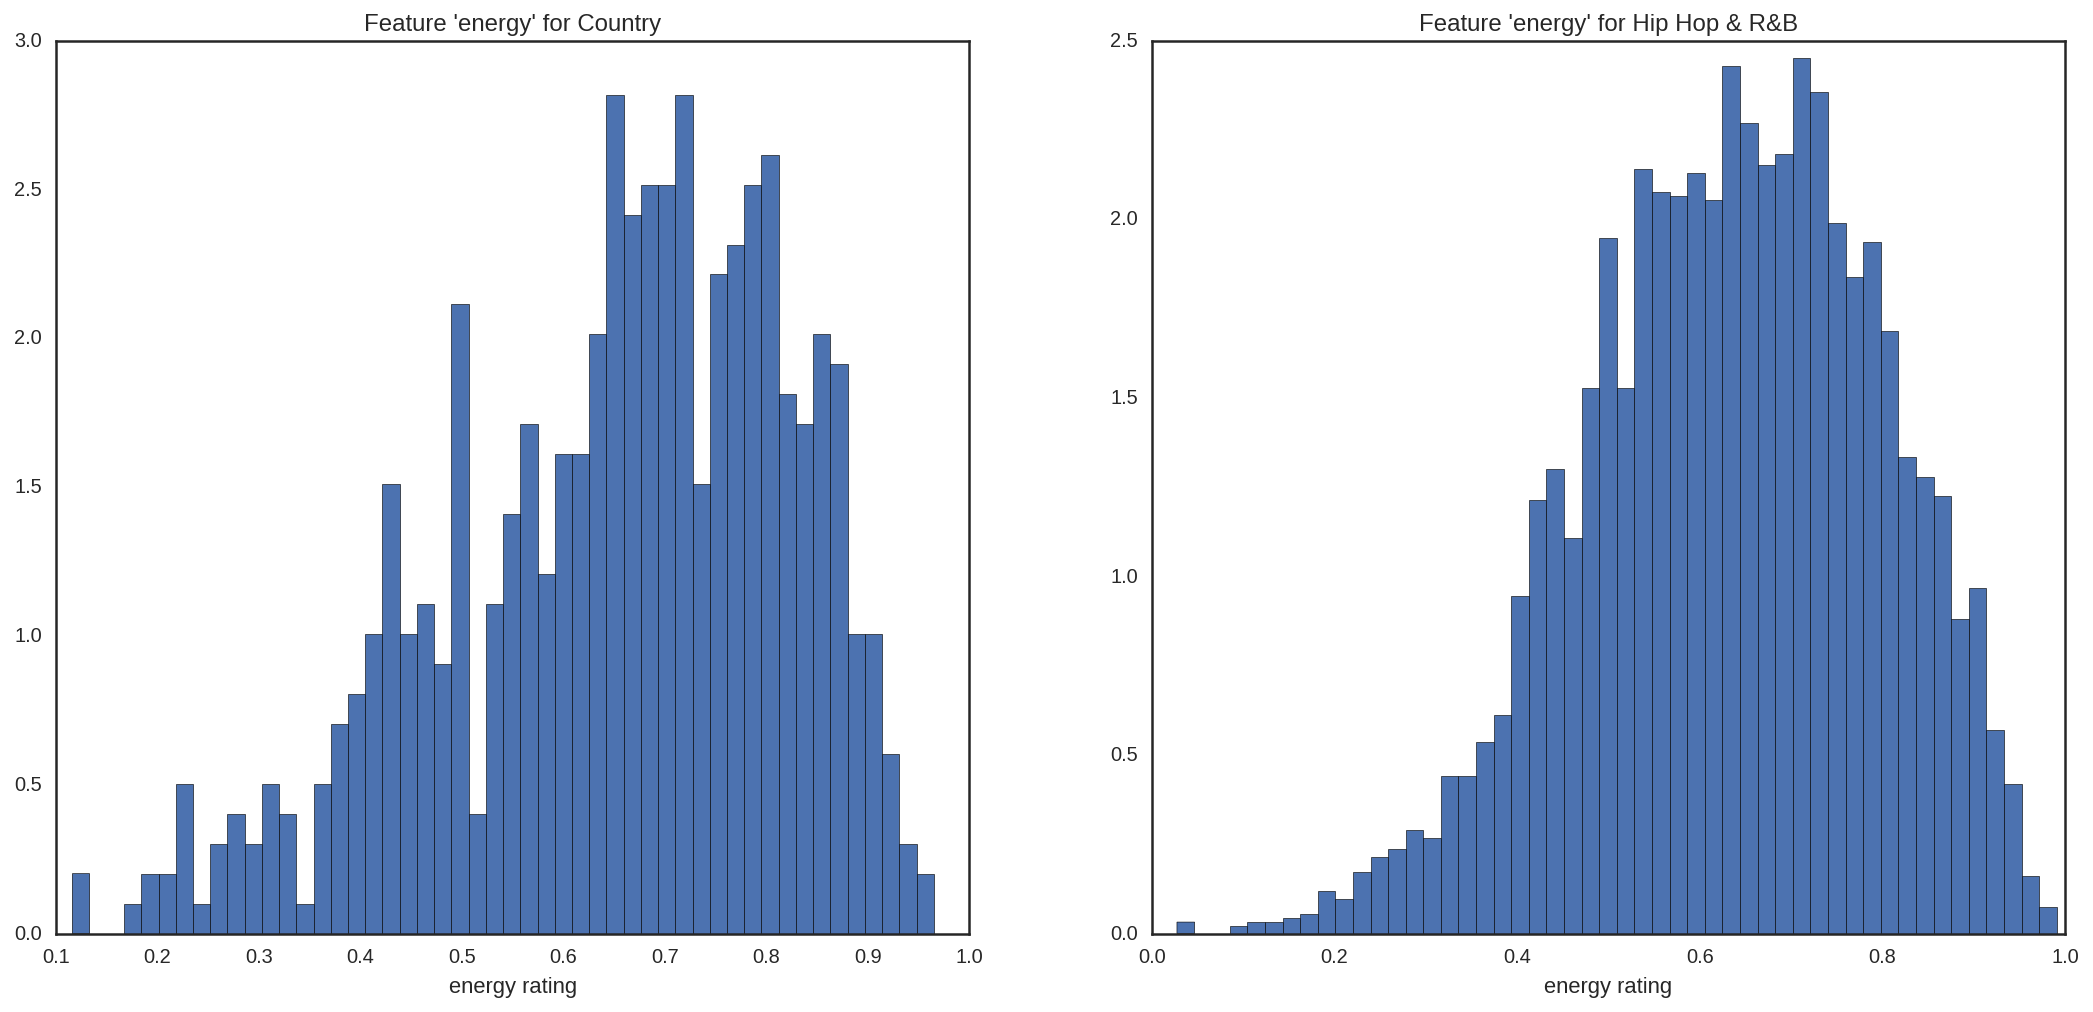

In [4]:
hist_of_feature('energy', country_features, hiphop_features);

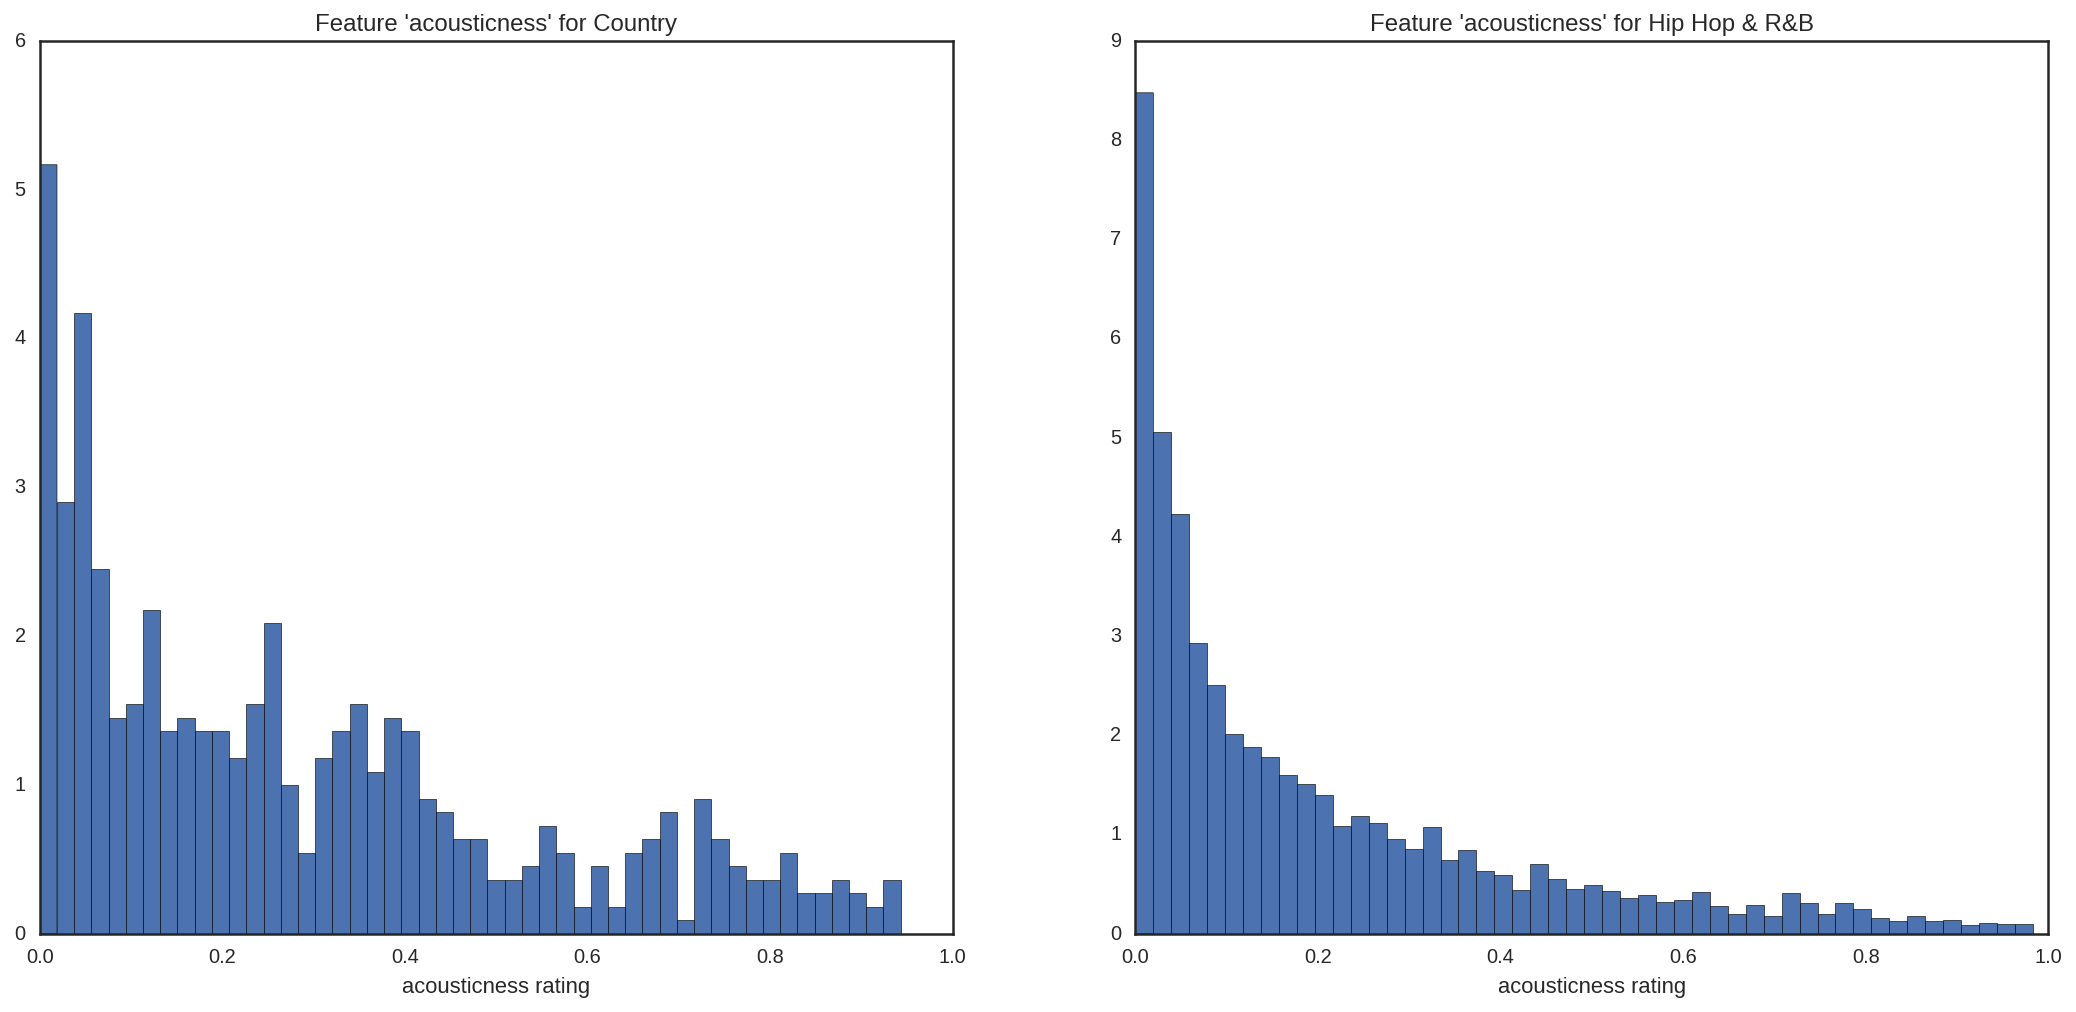

In [5]:
hist_of_feature('acousticness', country_features, hiphop_features);

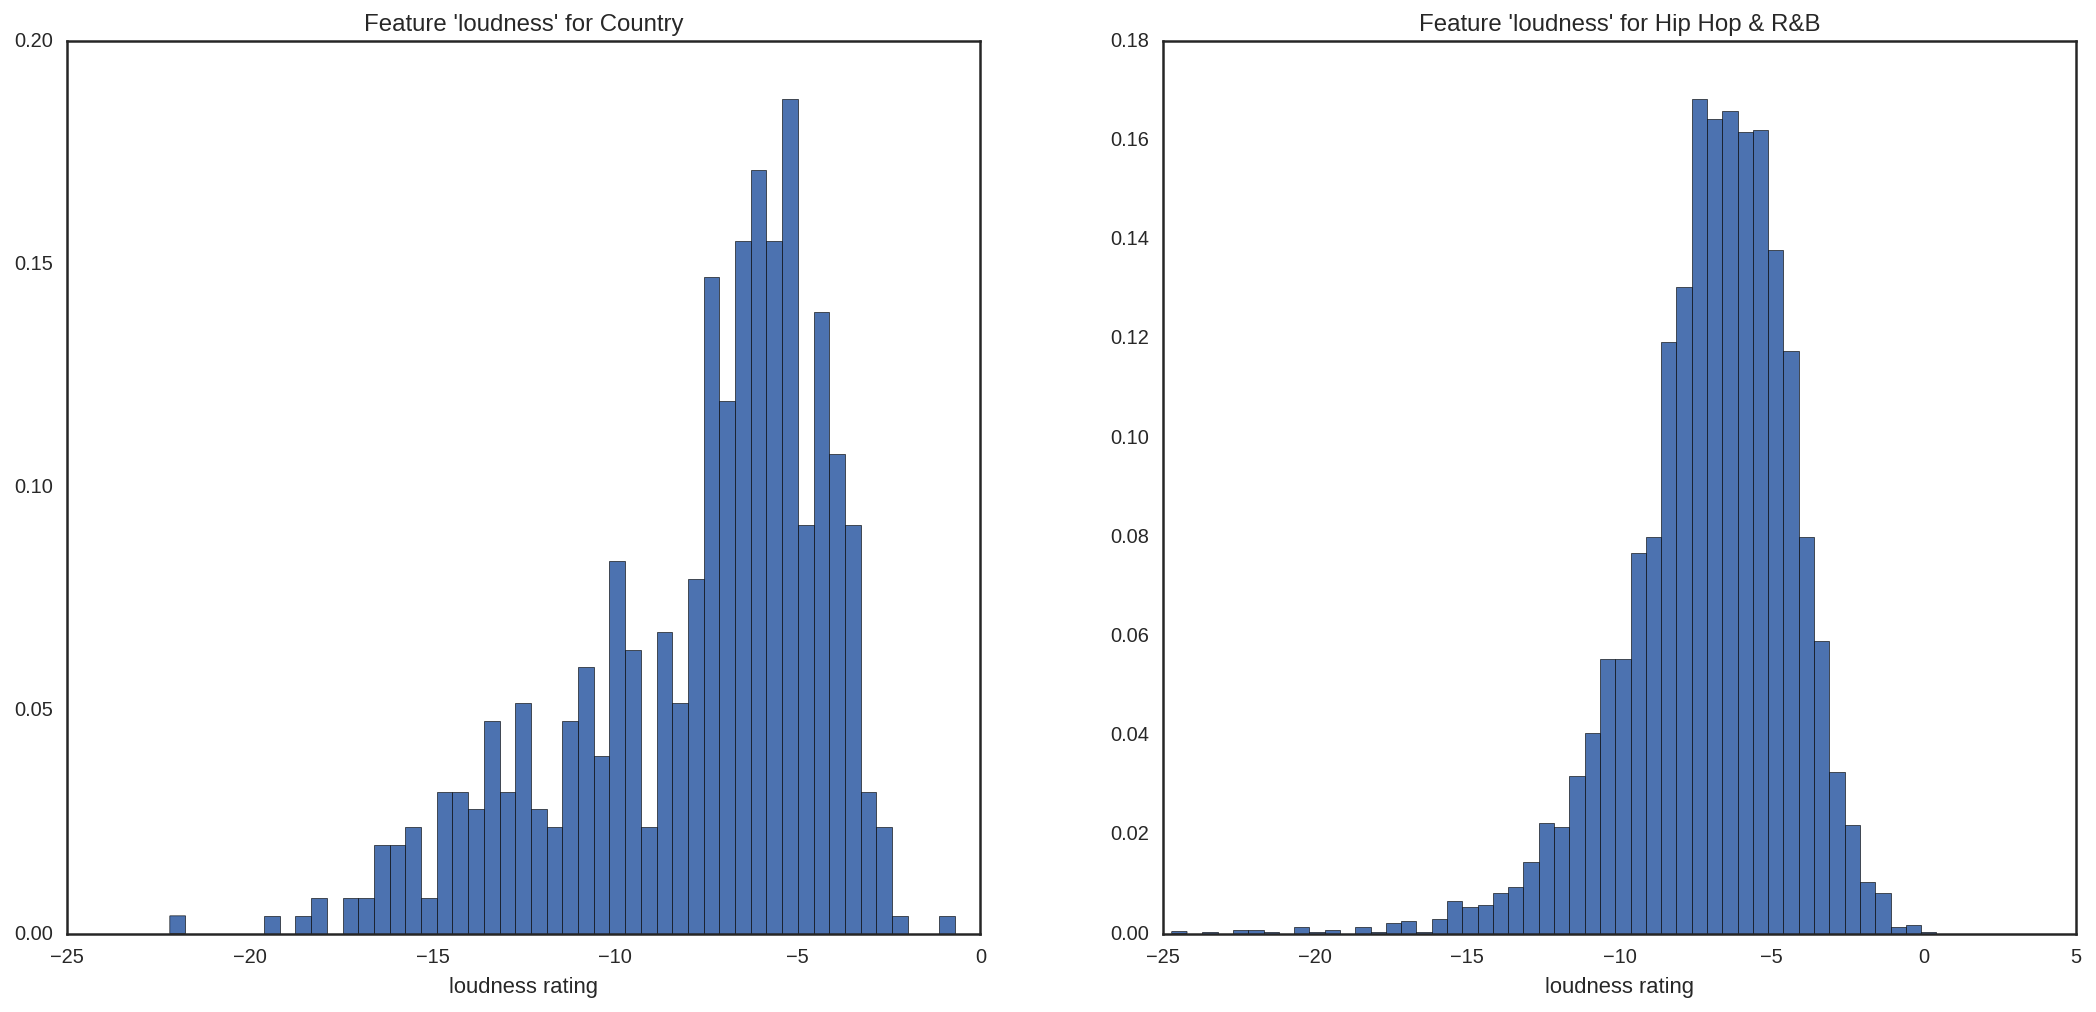

In [6]:
hist_of_feature('loudness', country_features, hiphop_features);

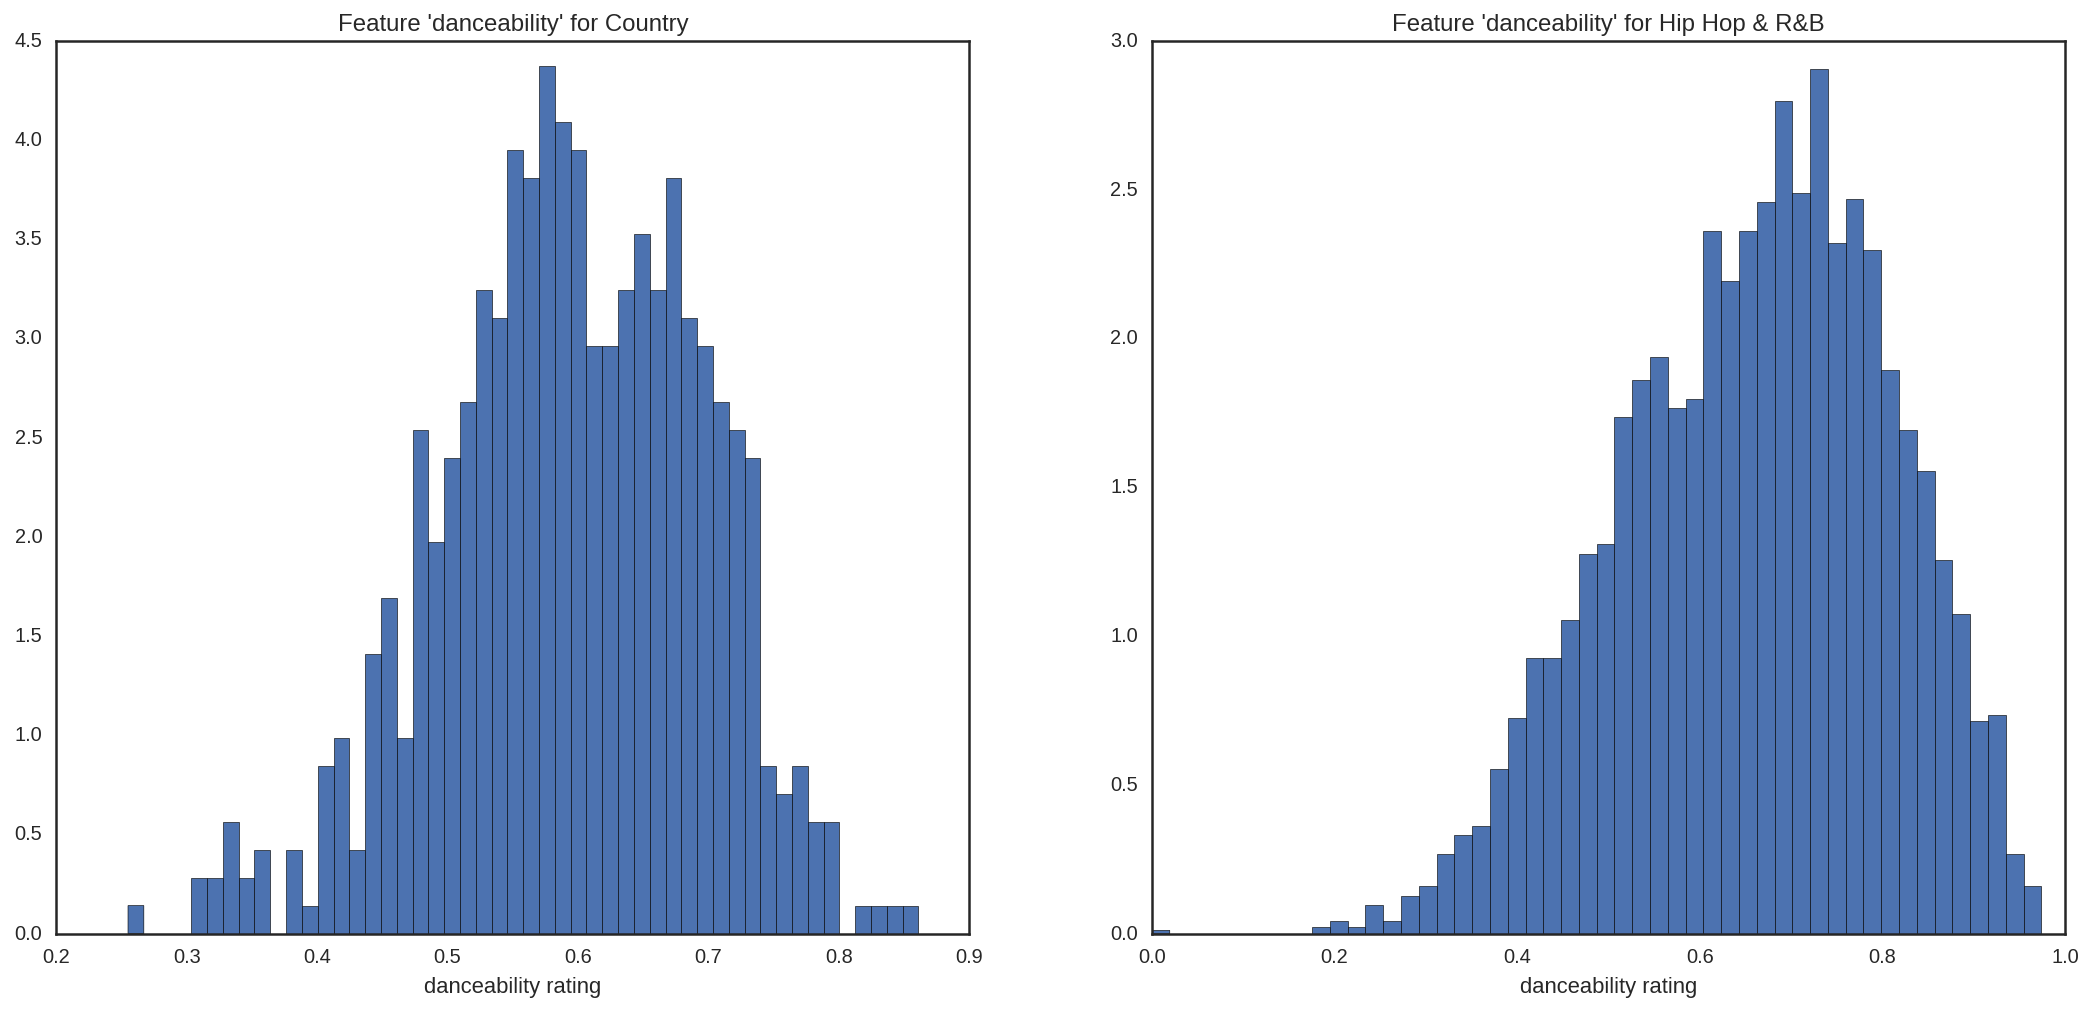

In [7]:
hist_of_feature('danceability', country_features, hiphop_features);

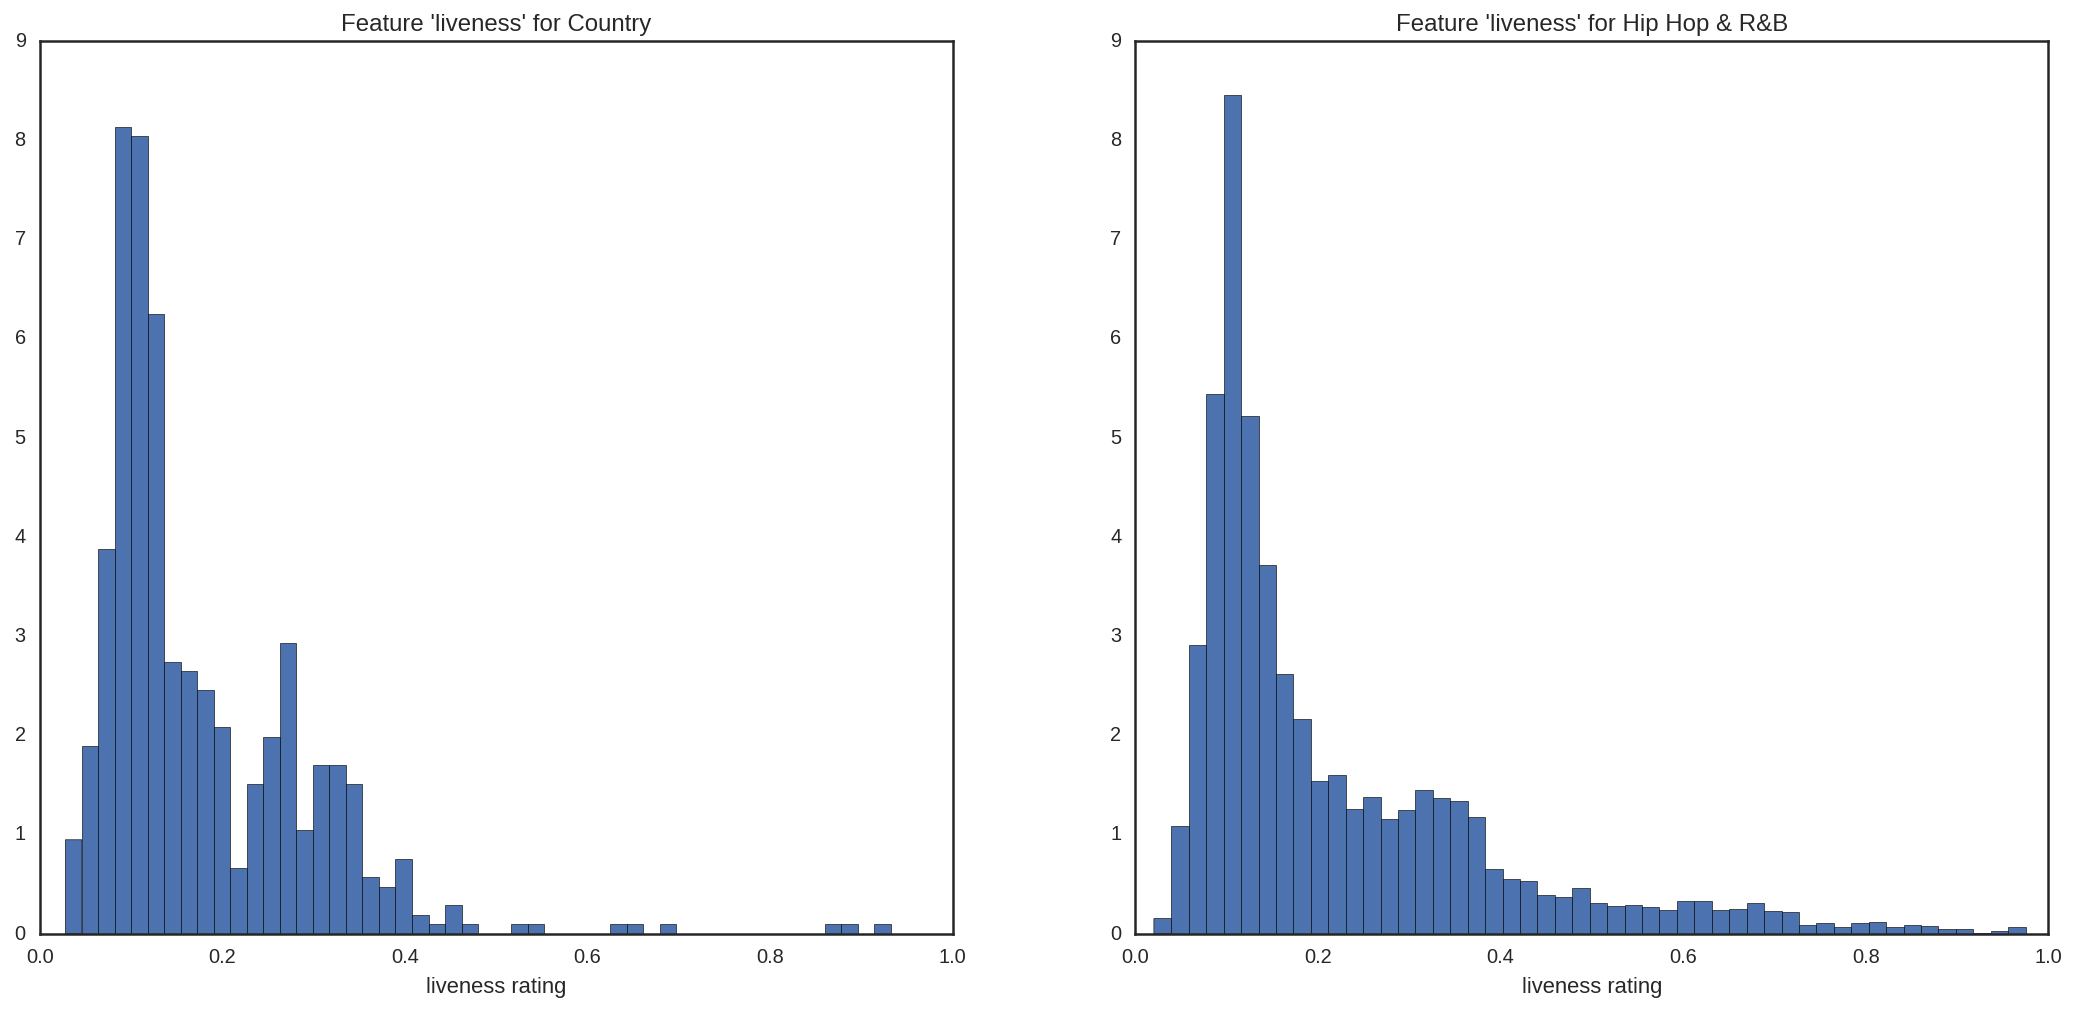

In [9]:
hist_of_feature('liveness', country_features, hiphop_features);

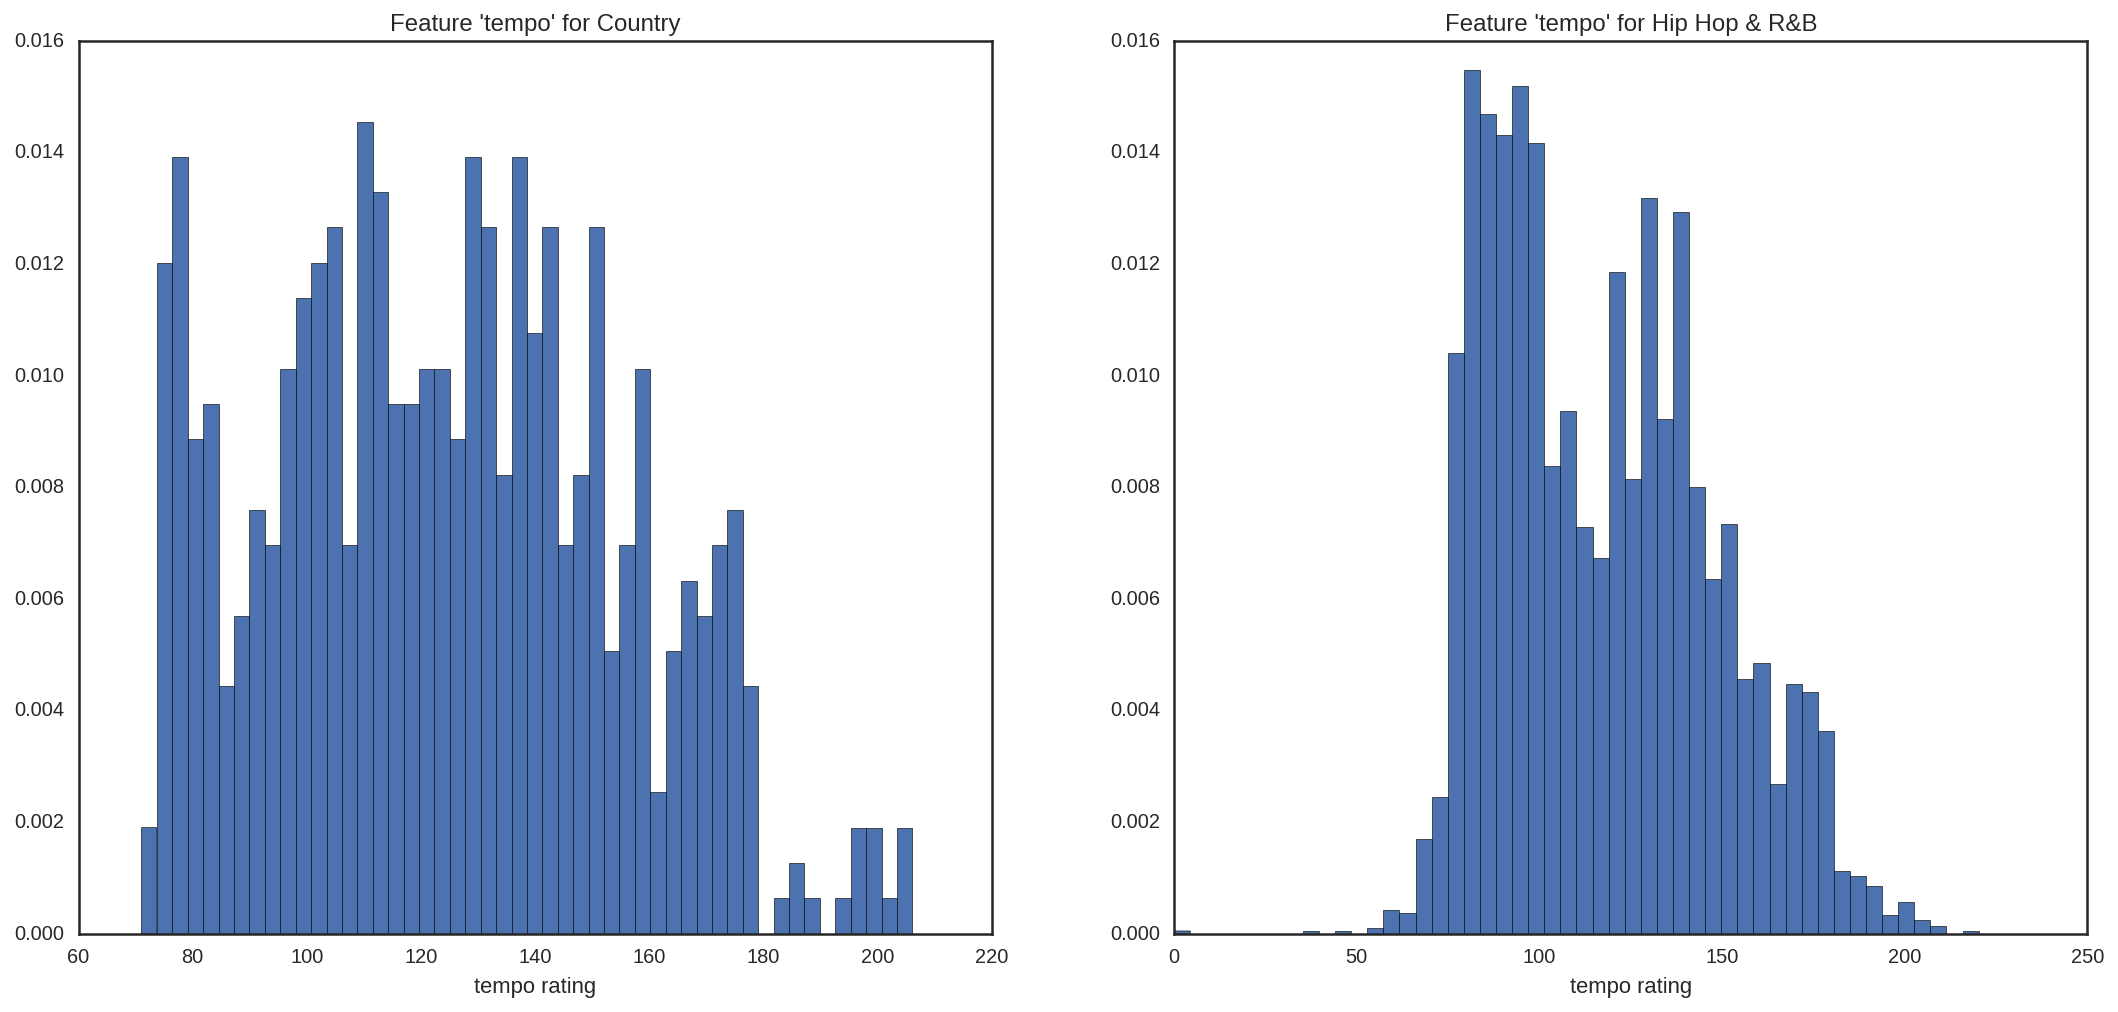

In [10]:
hist_of_feature('tempo', country_features, hiphop_features);

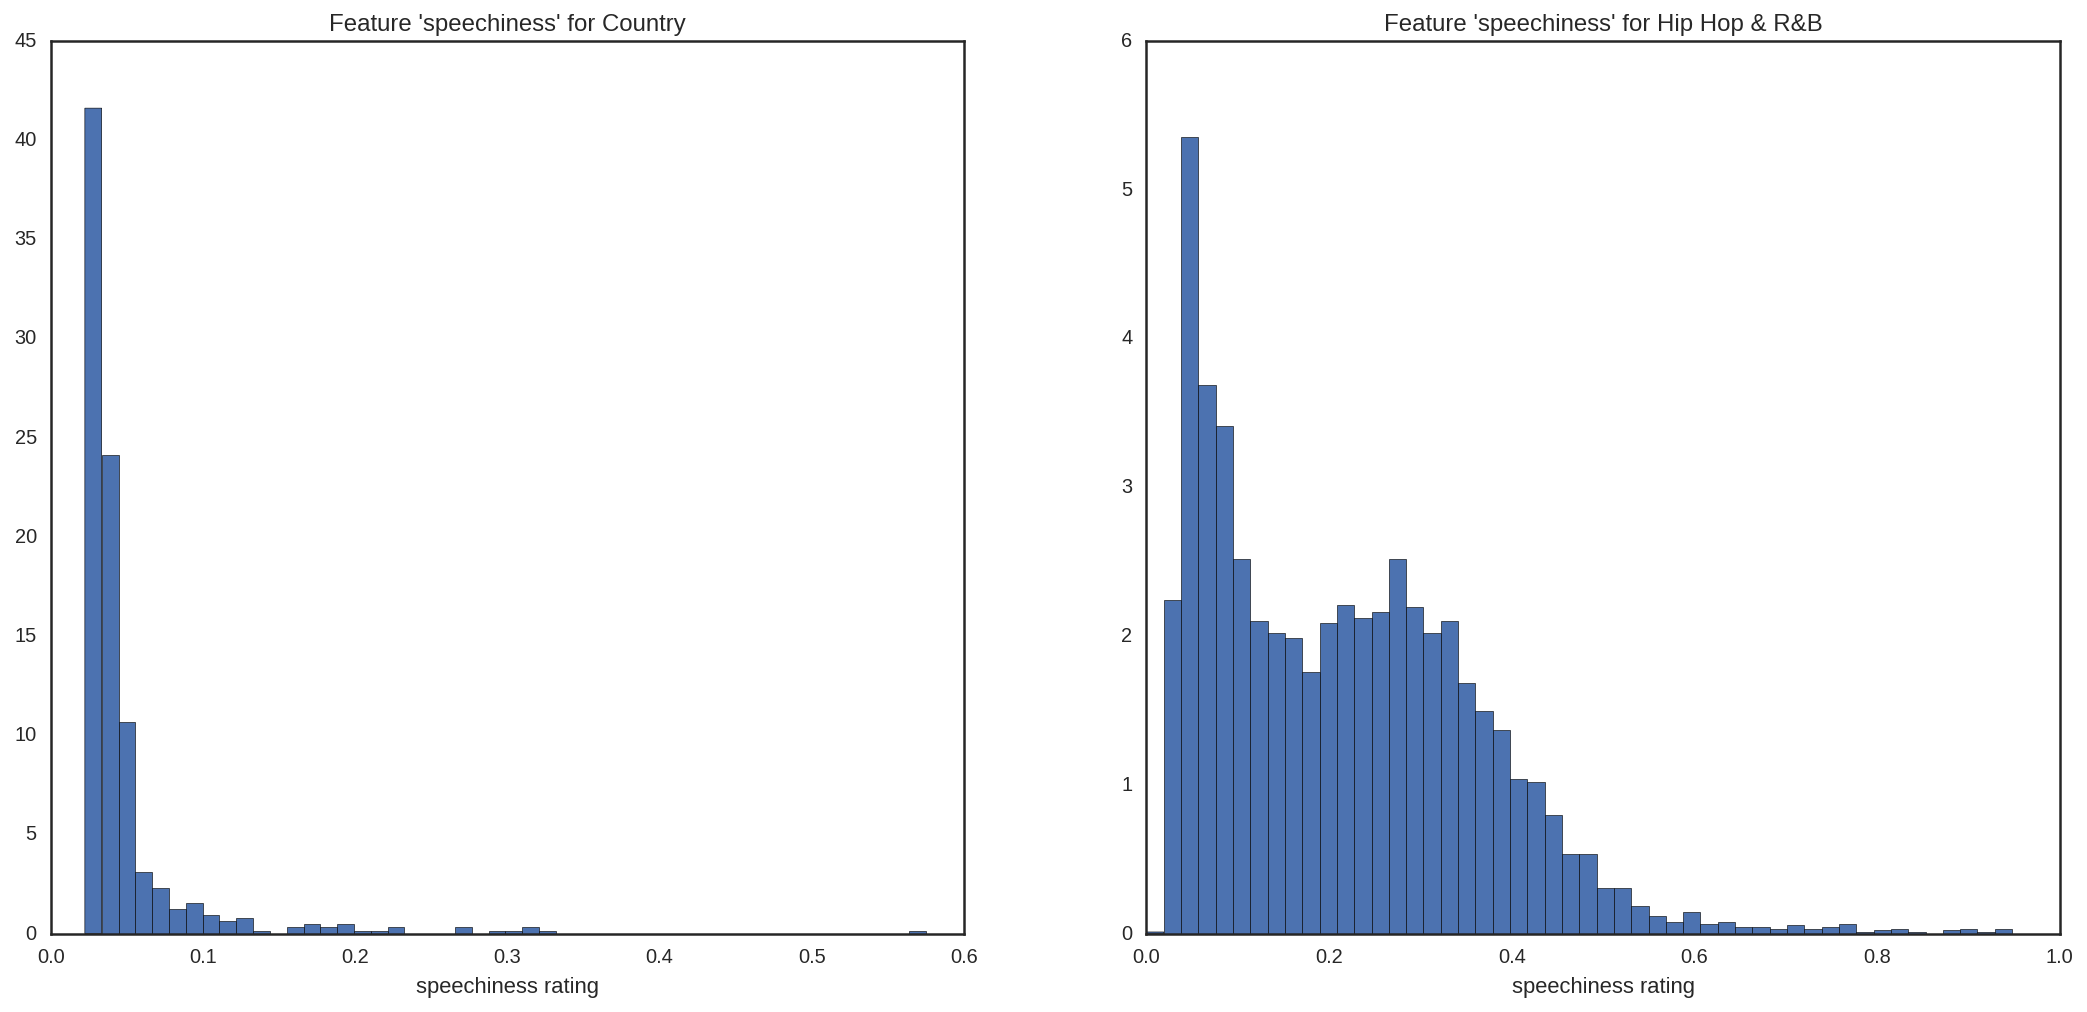

In [11]:
hist_of_feature('speechiness', country_features, hiphop_features);

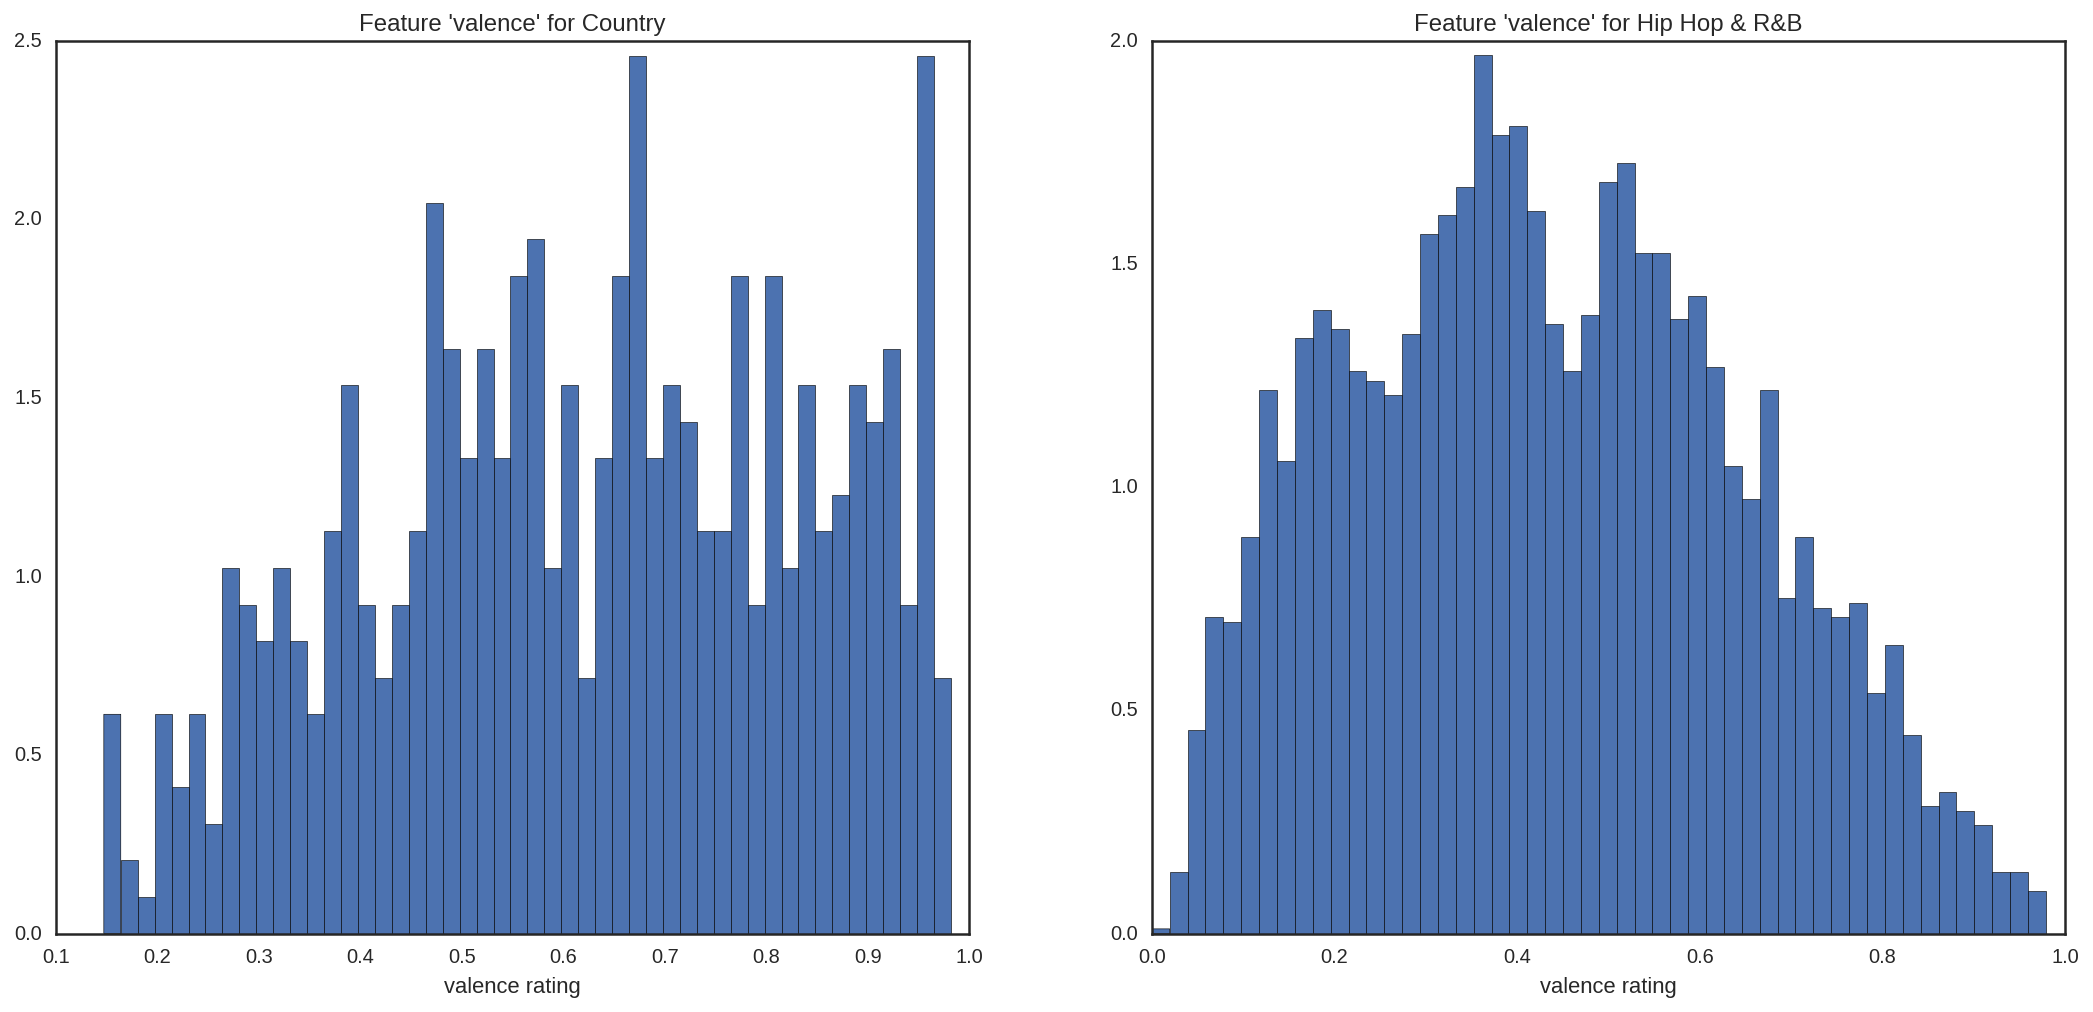

In [12]:
hist_of_feature('valence', country_features, hiphop_features);

In [15]:
import re
from collections import Counter, defaultdict


# Artist_collaboration_network[artist][collaborations] (directional graph)
def collaborating_artists(track):
    return [collab_artist['name'] for collab_artist in track['track']['artists']]
   

def collaboration_network(tracks):
    collab_network = defaultdict(Counter)
    
    for t in tracks:
        collabs = collaborating_artists(t)
        
        if len(collabs) > 1: #single list is artist itself
            for artist in collabs:
                collab_network[artist].update({c : 1 for c in collabs if c is not artist})

    return collab_network

collab_hiphop   = collaboration_network(hip_hop)
collab_country  = collaboration_network(country_1)
collab_country.update(collaboration_network(country_2))

In [16]:
def get_random_sample(genre, iters = 20):
    
    query = s.search(q='genre:{0}'.format(genre))
    tracks = []
    
    i = 0
    
    while query['tracks']['next']:
        tracks.extend(query['tracks']['items'])
        query = s.next(query['tracks'])
        
        i += 1
        
        if i == iters:
            break
  
    return tracks

In [17]:
sample = get_random_sample('rock', 100)

In [61]:
import numbers
def getDataframe(features):
    matrix = []
    metamatrix = []
    for track in features:
        try:
            matrix += [[x for x in track.values() if isinstance(x, numbers.Number)]]
            metamatrix += [[x for x in track.values() if not isinstance(x, numbers.Number)]]

        except:
            i = 0
    return np.array(matrix), metamatrix

#[ unicode(x.strip()) if x is not None else '' for x in row ]

In [62]:
getDataframe(hiphop_features)

(array([[  1.75000000e-01,   5.90000000e-01,   3.66000000e-01, ...,
           2.20995000e+05,   5.33000000e-01,   5.86000000e-01],
        [  6.14000000e-01,   7.64000000e-01,   3.87000000e-01, ...,
           2.10495000e+05,   8.01000000e-01,   6.44000000e-01],
        [  1.98000000e-01,   5.93000000e-01,   3.69000000e-01, ...,
           3.61942000e+05,   6.92000000e-01,   5.50000000e-01],
        ..., 
        [  3.01000000e-01,   8.27000000e-01,   2.78000000e-01, ...,
           2.45063000e+05,   7.14000000e-01,   6.07000000e-01],
        [  8.56000000e-02,   9.15000000e-01,   4.06000000e-01, ...,
           2.32533000e+05,   6.67000000e-01,   7.22000000e-01],
        [  9.29000000e-02,   7.36000000e-01,   2.95000000e-01, ...,
           2.34200000e+05,   7.26000000e-01,   7.87000000e-01]]),
 [['https://api.spotify.com/v1/audio-analysis/6vXY7pIIm05X7d87nolBMM',
   'spotify:track:6vXY7pIIm05X7d87nolBMM',
   '6vXY7pIIm05X7d87nolBMM',
   'https://api.spotify.com/v1/tracks/6vXY7pIIm05

In [38]:
hiphop_features[4700:]

[{'acousticness': 0.00344,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/3QFmH99wPoNdU2JHwKpajc',
  'danceability': 0.595,
  'duration_ms': 223187,
  'energy': 0.548,
  'id': '3QFmH99wPoNdU2JHwKpajc',
  'instrumentalness': 0,
  'key': 7,
  'liveness': 0.134,
  'loudness': -6.761,
  'mode': 0,
  'speechiness': 0.115,
  'tempo': 188.082,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/3QFmH99wPoNdU2JHwKpajc',
  'type': 'audio_features',
  'uri': 'spotify:track:3QFmH99wPoNdU2JHwKpajc',
  'valence': 0.563},
 {'acousticness': 0.0209,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5k6Xyiw1mL7VnWeVmzGG55',
  'danceability': 0.381,
  'duration_ms': 197107,
  'energy': 0.773,
  'id': '5k6Xyiw1mL7VnWeVmzGG55',
  'instrumentalness': 0,
  'key': 11,
  'liveness': 0.331,
  'loudness': -7.028,
  'mode': 1,
  'speechiness': 0.443,
  'tempo': 89.928,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/5k6Xyiw1mL7VnWeVmzGG55',